pendências
- [x] Procurar sobre importância de atributos
- [x] Calcular acurácia dos modelos
- [x] Fazer previsão por liga

# Imports e carregamentos

In [1]:
import pandas as pd
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

## Preprocessamento

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    print("Dados separados em características (X) e variável alvo (y).")
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    
    print("Preprocessador criado com transformações para características numéricas e categóricas.")
    return preprocessor.fit(X)

# # Preparando os dados
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)
print("Preprocessador ajustado aos dados.")

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor.pickle'.")

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
print("Dados transformados pelo preprocessador.")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
print("Dados divididos em conjuntos de treino e teste.")

Dados separados em características (X) e variável alvo (y).
Preprocessador criado com transformações para características numéricas e categóricas.
Preprocessador ajustado aos dados.
Preprocessador salvo em '../models/preprocessor.pickle'.
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.


## Rede Neural no Keras: Treinamento e Avaliação 

### Contrução do modelo, salvamento, visualização treino e teste

Epoch 1/300
928/928 [==============================] - 3s 2ms/step - loss: 0.7040 - accuracy: 0.5300 - auc: 0.5451 - val_loss: 0.6950 - val_accuracy: 0.5527 - val_auc: 0.5804
Epoch 2/300
928/928 [==============================] - 2s 2ms/step - loss: 0.6955 - accuracy: 0.5488 - auc: 0.5705 - val_loss: 0.6916 - val_accuracy: 0.5608 - val_auc: 0.5860
Epoch 3/300
928/928 [==============================] - 2s 2ms/step - loss: 0.6914 - accuracy: 0.5536 - auc: 0.5806 - val_loss: 0.6888 - val_accuracy: 0.5559 - val_auc: 0.5883
Epoch 4/300
928/928 [==============================] - 2s 2ms/step - loss: 0.6883 - accuracy: 0.5611 - auc: 0.5899 - val_loss: 0.6870 - val_accuracy: 0.5622 - val_auc: 0.5962
Epoch 5/300
928/928 [==============================] - 2s 2ms/step - loss: 0.6846 - accuracy: 0.5685 - auc: 0.6017 - val_loss: 0.6831 - val_accuracy: 0.5703 - val_auc: 0.6047
Epoch 6/300
928/928 [==============================] - 2s 2ms/step - loss: 0.6811 - accuracy: 0.5757 - auc: 0.6122 - val_loss

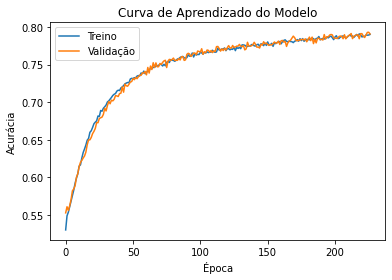

In [4]:
from sklearn.metrics import roc_auc_score
from keras.regularizers import l2
import tensorflow as tf  # Import the l2 regularizer


model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.00005)))  # Regularização ligeiramente reduzida
model.add(Dropout(0.25))  # Dropout ligeiramente reduzido
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.00005)))  # Regularização ligeiramente reduzida
model.add(Dropout(0.25))  # Dropout ligeiramente reduzido
model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# Mantendo a taxa de aprendizado e o tamanho do batch do último ajuste
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])

# Aumentando a paciência no EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=15)  # Paciência aumentada para permitir mais treinamento

# Treinando o modelo com mais épocas
history = model.fit(X_train, y_train, epochs=300, batch_size=64,  # Aumento do número de épocas
                    validation_split=0.2,
                    callbacks=[early_stop], verbose=1)

# Avaliando a acurácia e AUC do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)
print('AUC no conjunto de treinamento:', train_auc)
print('AUC no conjunto de teste:', test_auc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# Salvando o modelo
model.save('../models/model_redeht_final.h5')

In [5]:
from sklearn.metrics import classification_report
import numpy as np

# Fazendo as predições no conjunto de teste
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0).flatten()  # Converter para 0s e 1s e achatar o array

# Obtendo os rótulos verdadeiros
y_true = y_test  # Substitua com o array correto de rótulos verdadeiros do conjunto de teste

# Gerando o relatório de classificação
report = classification_report(y_true, predictions, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)


580/580 [==============================] - 0s 717us/step
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.78      0.80      0.79      9529
    Classe 1       0.78      0.76      0.77      9015

    accuracy                           0.78     18544
   macro avg       0.78      0.78      0.78     18544
weighted avg       0.78      0.78      0.78     18544



## Visualizando características importantes

In [6]:
from keras.models import load_model
model = load_model('../models/model_redeht_final.h5')

import shap
# Criando o explainer
explainer = shap.DeepExplainer(model, X_train)
# Subconjunto do conjunto de teste para análise
X_test_sample = X_test[:200]  # Ajuste o tamanho da amostra conforme necessário

# Calculando os valores SHAP
shap_values = explainer.shap_values(X_test_sample)
# Plotando um gráfico de resumo
# shap.summary_plot(shap_values, X_test_sample)

# Obter os nomes das colunas numéricas
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Obter os nomes das colunas após a transformação
# Para as características numéricas, permanecem os mesmos
transformed_numeric_features = numeric_features

# Como só tem uma característica categórica:
categories = preprocessor.named_transformers_['cat'].categories_
transformed_categorical_features = [
    f'league_{category}' for category in categories[0][1:]  # drop='first' remove a primeira categoria
]

# Combina os dois
all_transformed_features = transformed_numeric_features + transformed_categorical_features

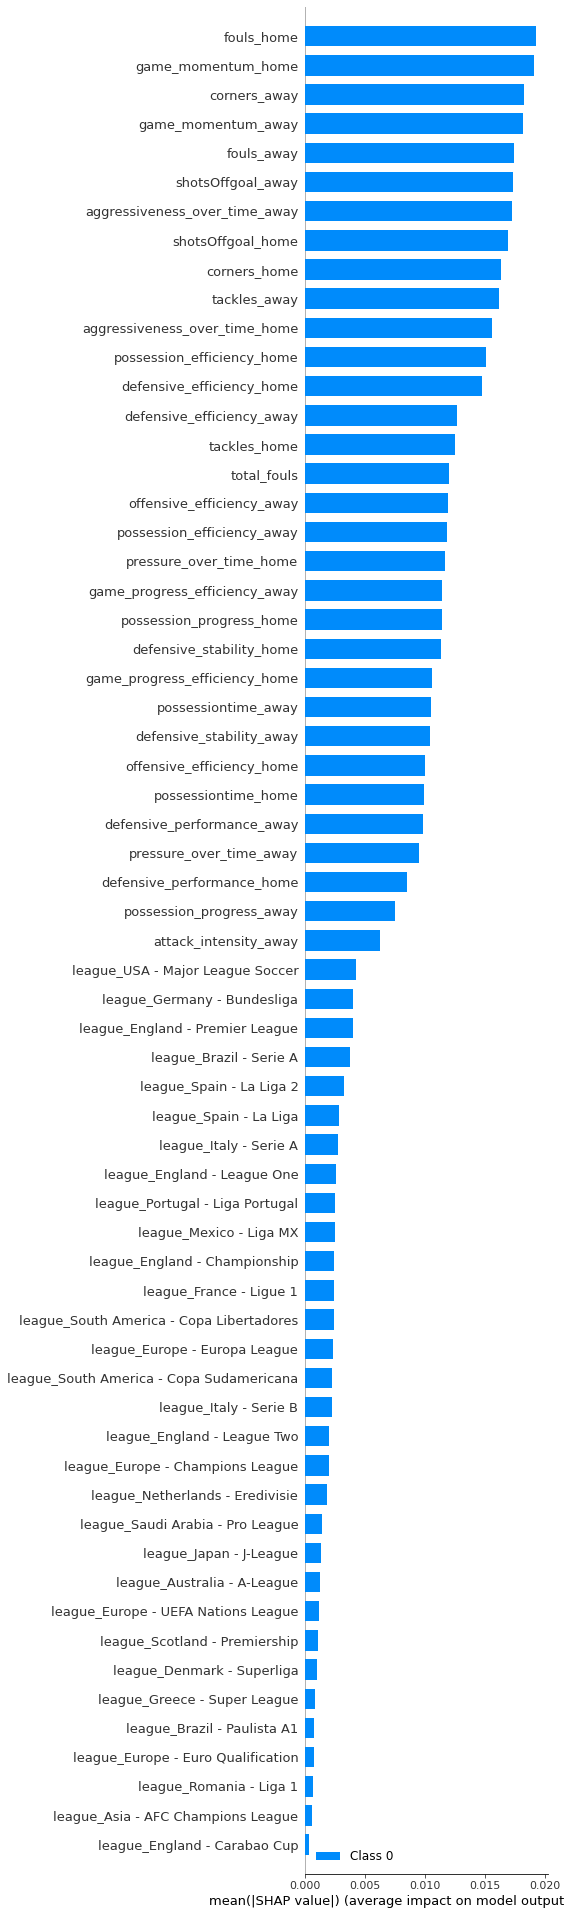

In [7]:
# Plotando um gráfico de resumo com nomes de features reais
shap.summary_plot(shap_values, features=X_test_sample, feature_names=all_transformed_features, max_display=X_test_sample.shape[1])